**1) Instalar libs necessárias**

In [1]:
!pip install geopandas
!pip install rasterio
!pip install GDAL

**2) Importar libs usadas**

In [2]:
import fiona
import gdal
import geopandas
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import ogr
import os
import rasterio
import rasterio.mask
from rasterio.features import shapes
from rasterio.enums import Resampling
from rasterio.plot import show
from scipy import ndimage as ndi
from skimage import io, filters, segmentation, color
import sys

**1. Leitura de metadados da imagem RGB**

In [3]:
def get_metadata(input_file, output_file):
  tif_file = rasterio.open(input_file)
  f_info = "SAMPLE \nCRS: " + str(tif_file.crs) + "\nGSD(cm/px): 1px equivale a aproximadamente " + str(round((tif_file.bounds.top - tif_file.bounds.bottom)/tif_file.height * 100)) + "cm.\n\n"
  f = open(output_file, "w")
  f.write(f_info)
  f.close()
  f = open(output_file, "r")
  print(f.read())

**2. Segmentação da imagem RGB**


In [4]:
def image_segmentation(input_file, aux_file, output_file):
  tif_file = gdal.Open(input_file)
  band1 = tif_file.GetRasterBand(1) # Canal R
  band2 = tif_file.GetRasterBand(2) # Canal G
  band3 = tif_file.GetRasterBand(3) # Canal B
  b1 = band1.ReadAsArray()
  b2 = band2.ReadAsArray()
  b3 = band3.ReadAsArray()

  img = np.dstack((b1, b2, b3))
  f = plt.figure()
  plt.imshow(img)
  plt.show()

  print('Figura 1:')
  print(f'Dimensões da imagem: {img.shape}')
  print(f'Altura: {img.shape[0]}')
  print(f'Largura: {img.shape[1]}')
  print("Valores de intensidade mínimo/máximo:", img.min(), img.max())

  print('Valor no canal R: {}'.format(img[ 100, 100, 0]))
  print('Valor no canal G: {}'.format(img[ 100, 100, 1]))
  print('Valor no canal B: {}'.format(img[ 100, 100, 2]))

  print('---------------------------------------------------------')

  img10=img[:, :, 0]
  img11=img[:, :, 1]
  img12=img[:, :, 2]

  plt.imshow(img11)
  plt.show()
  
  # criar filtro para a segmentacao
  filtered_image1 = filters.sobel(img11)
  plt.imshow(filtered_image1)
  plt.show()
  
  # criar marcadores para a segmentacao
  marcadores11 = np.zeros_like(img11)
  marcadores11[img11 < 150] = 1
  marcadores11[img11 < 100] = 2

  plt.imshow(marcadores11)
  plt.show()

  # segmentação
  img_seg = segmentation.watershed(filtered_image1, marcadores11)
  img_seg = ndi.binary_closing(img_seg-1)

  plt.imshow(img_seg)
  plt.show()
  io.imsave(aux_file, img_seg)

  #salvar imagem segmentada
  segmentada = rasterio.open(aux_file)
  segmentada = segmentada.read([1])
  segmentada = segmentada.astype('uint16')
  show(segmentada)

  with rasterio.open(input_file) as naip:
      with rasterio.open(output_file,'w', driver='GTiff',
          count=segmentada.shape[0], height=segmentada.shape[1], 
          width=segmentada.shape[2], dtype=segmentada.dtype, crs=naip.crs, 
          transform=naip.transform
          ) as dst:
              dst.write(segmentada)

**3. Vetorização das regiões segmentadas**



In [5]:
def vectorize(input_file, aux_file, output_file, driver='ESRI Shapefile'):
    with rasterio.open(input_file) as segmented:
        image = segmented.read(1)
        mask = None
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(
                shapes(image, mask=mask, transform=segmented.transform)))

        with fiona.open(
            aux_file, 'w',
            driver=driver,
            crs=segmented.crs,
            schema={'properties': [('raster_val', 'int')],
                    'geometry': 'Polygon'}) as dst:

            dst.writerecords(results)

        driver = ogr.GetDriverByName('ESRI Shapefile')
        data_source = driver.Open(aux_file, 0)

        fc = {'type': 'FeatureCollection', 'features': [] }
        lyr = data_source.GetLayer(0)
        for feature in lyr:    
            fc['features'].append(feature.ExportToJson(as_object=True))

        with open(output_file, 'w') as f:
          json.dump(fc, f)



**4. Contagem de árvores**

In [15]:
def count_tree(input_file, output_file):
  file = open(input_file)
  df = geopandas.read_file(file)
  print(df.area.mean())
  print(df.area.min())
  print(df.area.max())

  count=0
  for index,row in df.iterrows():
    if(row['geometry'].area < 7 and row['geometry'].area >0.2):
      count+=1

  f_info = "Quantidade de eucaliptos identificados: aproximadamente " + str(count) 
  f = open(output_file, "w")
  f.write(f_info)
  f.close()
  f = open(output_file, "r")
  print(f.read())



**5. Execução**

SAMPLE 1

PARTE I: METADADOS

SAMPLE 
CRS: EPSG:32722
GSD(cm/px): 1px equivale a aproximadamente 6cm.


PARTE II: SEGMENTAÇÃO



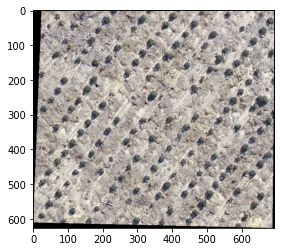

Figura 1:
Dimensões da imagem: (626, 694, 3)
Altura: 626
Largura: 694
Valores de intensidade mínimo/máximo: 0 254
Valor no canal R: 161
Valor no canal G: 150
Valor no canal B: 141
---------------------------------------------------------


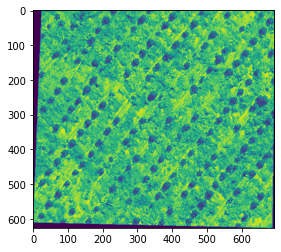

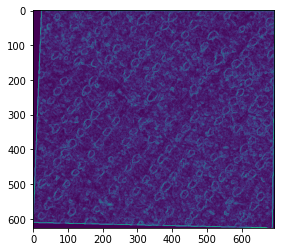

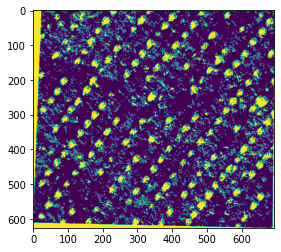

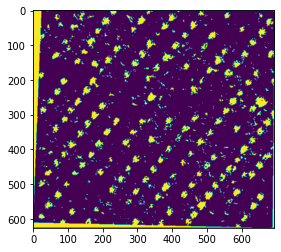

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: img_seg1.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


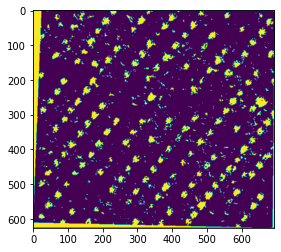

PARTE III: VETORIZAÇÃO

PARTE IV: CONTAGEM



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


1.4672946479631006
0.003455088375122527
1303.8881705757426
Quantidade de eucaliptos identificados: aproximadamente 153

------------------------------------------------------------

SAMPLE 2

PARTE I: METADADOS

SAMPLE 
CRS: EPSG:32722
GSD(cm/px): 1px equivale a aproximadamente 6cm.


PARTE II: SEGMENTAÇÃO



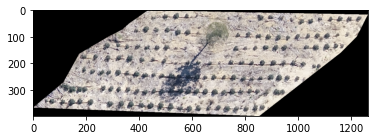

Figura 1:
Dimensões da imagem: (398, 1263, 3)
Altura: 398
Largura: 1263
Valores de intensidade mínimo/máximo: 0 254
Valor no canal R: 0
Valor no canal G: 0
Valor no canal B: 0
---------------------------------------------------------


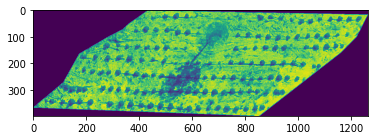

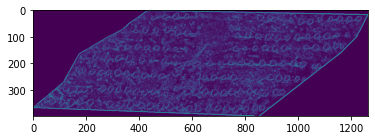

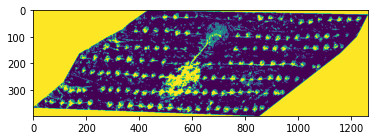

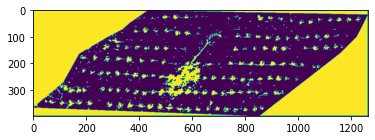

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: img_seg2.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


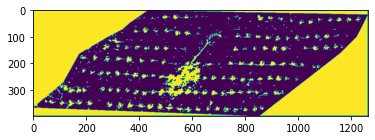

PARTE III: VETORIZAÇÃO

PARTE IV: CONTAGEM

2.238122559763706
0.003455088375122527
1061.8246772048012
Quantidade de eucaliptos identificados: aproximadamente 133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [16]:
#SAMPLE 1
print("SAMPLE 1\n")
print("PARTE I: METADADOS\n")
get_metadata('sample1.tif', 'metadata1.txt')
print("PARTE II: SEGMENTAÇÃO\n")
image_segmentation('sample1.tif', 'img_seg1.png', 'segmented1.tif')
print("PARTE III: VETORIZAÇÃO\n")
vectorize('segmented1.tif', 'vectorized1.shp', 'vectorized1.geojson')
print("PARTE IV: CONTAGEM\n")
count_tree('vectorized1.geojson', 'qtd_eucalipto1.txt')

#SAMPLE 2
print("\n------------------------------------------------------------\n\nSAMPLE 2\n")
print("PARTE I: METADADOS\n")
get_metadata('sample2.tif', 'metadata2.txt')
print("PARTE II: SEGMENTAÇÃO\n")
image_segmentation('sample2.tif', 'img_seg2.png', 'segmented2.tif')
print("PARTE III: VETORIZAÇÃO\n")
vectorize('segmented2.tif', 'vectorized2.shp', 'vectorized2.geojson')
print("PARTE IV: CONTAGEM\n")
count_tree('vectorized2.geojson', 'qtd_eucalipto2.txt')

In [3]:
!pip freeze > requirements.txt